In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
data=pd.read_csv('data_urls.csv')

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822010 entries, 0 to 822009
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     822010 non-null  object
 1   status  822010 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.5+ MB


In [116]:
data['url_length'] = data['url'].apply(len)
data['class']=data['status'].apply(lambda x:  'phishing'if x==0 else 'legitimate')
data['num_special_chars'] = data['url'].apply(lambda x: sum([1 for char in x if char in ['@', '-', '?', '=']]))
data['num_subdomains'] = data['url'].apply(lambda x: len(x.split('.')) - 2)
data['num_digits']=data['url'].apply(lambda x: sum([1 for char in x if str(char).isdigit()]))
data['num_dots']= data['url'].apply(lambda x: sum([1 for char in x if char=='.']))
data['tld'] = data['url'].apply(lambda x: x.split('.')[-1])

In [117]:
data['url_length']

0         39
1         36
2         12
3         35
4         20
          ..
822005     9
822006     6
822007     9
822008    16
822009    42
Name: url_length, Length: 822010, dtype: int64

In [118]:
data['url_length'].describe()

count    822010.000000
mean         47.089802
std          42.556054
min           1.000000
25%          26.000000
50%          37.000000
75%          55.000000
max        3992.000000
Name: url_length, dtype: float64

In [119]:
data['num_special_chars']

0         0
1         0
2         0
3         0
4         0
         ..
822005    0
822006    0
822007    0
822008    0
822009    2
Name: num_special_chars, Length: 822010, dtype: int64

In [120]:
data['num_special_chars'].describe()

count    822010.000000
mean          1.341099
std           2.505930
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         197.000000
Name: num_special_chars, dtype: float64

In [121]:
data['num_subdomains']

0         1
1         1
2         0
3         1
4         1
         ..
822005    0
822006    0
822007    1
822008    1
822009    3
Name: num_subdomains, Length: 822010, dtype: int64

In [122]:
data['num_subdomains'].describe()

count    822010.000000
mean          1.132614
std           1.505595
min          -1.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          36.000000
Name: num_subdomains, dtype: float64

In [123]:
data['num_digits']

0         7
1         6
2         5
3         4
4         5
         ..
822005    0
822006    0
822007    0
822008    0
822009    4
Name: num_digits, Length: 822010, dtype: int64

In [124]:
data['num_digits'].describe()

count    822010.000000
mean          3.985646
std          10.932098
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max        1575.000000
Name: num_digits, dtype: float64

In [125]:
data['num_dots']

0         2
1         2
2         1
3         2
4         2
         ..
822005    1
822006    1
822007    2
822008    2
822009    4
Name: num_dots, Length: 822010, dtype: int64

In [126]:
data['num_dots'].describe

<bound method NDFrame.describe of 0         2
1         2
2         1
3         2
4         2
         ..
822005    1
822006    1
822007    2
822008    2
822009    4
Name: num_dots, Length: 822010, dtype: int64>

In [127]:
data['tld']

0            com
1            com
2         online
3            com
4            com
           ...  
822005       com
822006        li
822007        uk
822008        za
822009       com
Name: tld, Length: 822010, dtype: object

In [128]:
data['tld'].describe()

count     822010
unique    327733
top         html
freq       82896
Name: tld, dtype: object

In [129]:
def tok(string) -> str:
    return string.replace('/', '.').split('.')

def to_txt(text) -> str:
    return text.replace('.', ' ').replace('/', ' ')
def top_terms(df, n) -> list[str]:
    term = {}
    for url in data['url']:
        for word in tok(url):
            if word != '':
                if word not in term.keys():
                    term[word] = 0

                term[word]+=1
            
    return [t[0] for t in sorted(term.items(), key=lambda x:x[1], reverse=True)[:n]]

tw=top_terms(data['url'], 15)
tw

['com',
 'https:',
 'www',
 'html',
 'http:',
 'org',
 'net',
 'cn',
 'php',
 'htm',
 'index',
 'co',
 'en',
 'login',
 'wiki']

In [130]:
data.head()

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,tld
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,1,7,2,com
1,000011accesswebform.godaddysites.com,0,36,phishing,0,1,6,2,com
2,00003.online,0,12,phishing,0,0,5,1,online
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,1,4,2,com
4,000n38p.wcomhost.com,0,20,phishing,0,1,5,2,com


/home/lab_services_student/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


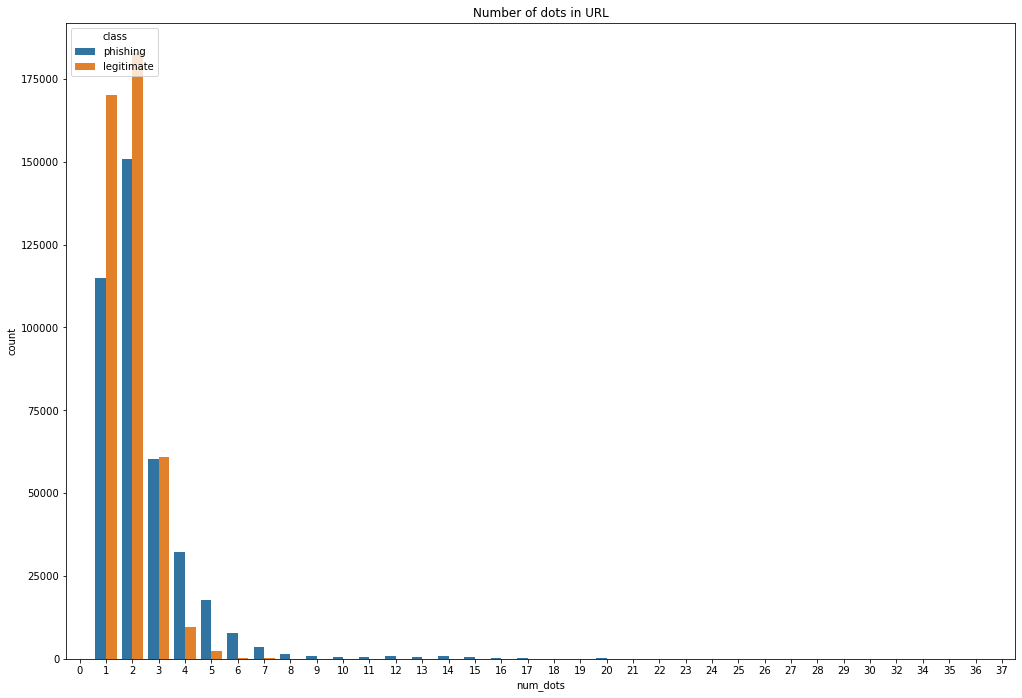

In [131]:

p=sns.countplot(data['num_dots'], hue=data['class'])
p.set_title("Number of dots in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)


/home/lab_services_student/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,tld
30528,https://pandas.fjchalke-co-uk.com/green/bnqsjz...,0,1631,phishing,4,1,1575,2,com/green/bnqsjz64x65f540be65ac66/?s=646566353...
40183,https://pandas.fjchalke-co-uk.com/green/bnqsjz...,0,1631,phishing,4,1,1575,2,com/green/bnqsjz64x65f540be65ac66/?s=646566353...


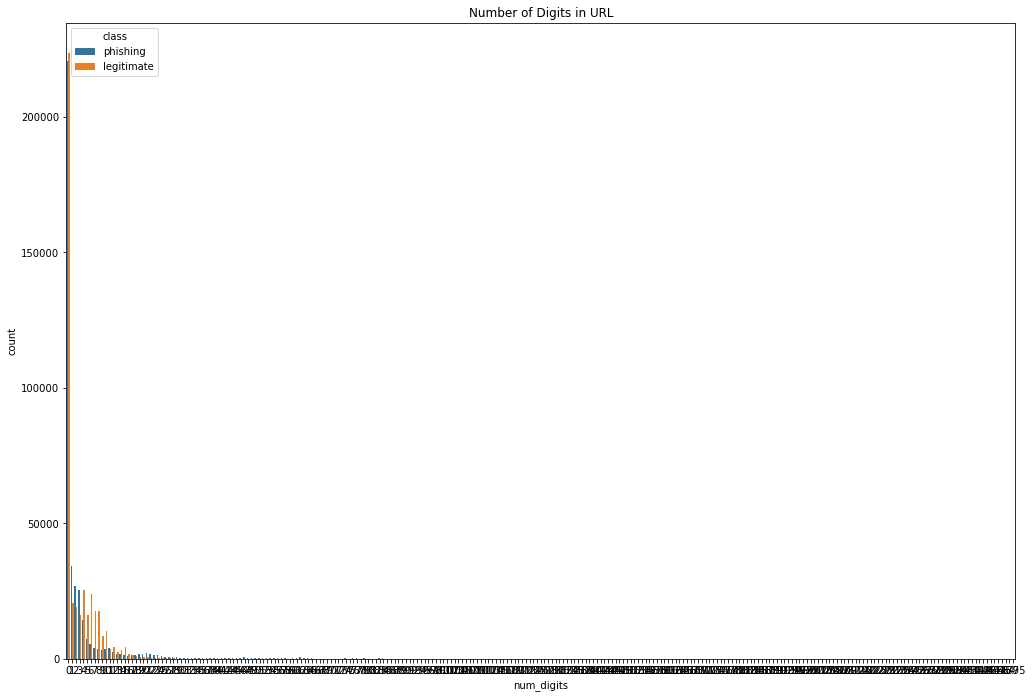

In [137]:

p=sns.countplot(data['num_digits'], hue=data['class'])
p.set_title("Number of Digits in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)
d=data[data['num_digits']>1570]
d

/home/lab_services_student/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


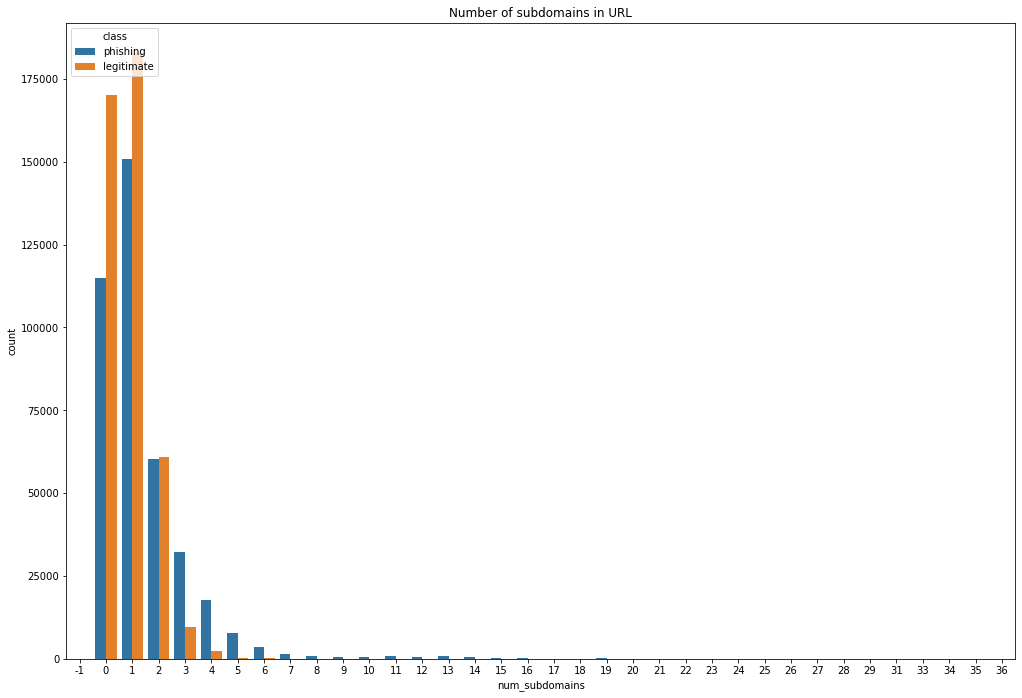

In [143]:

p=sns.countplot(data['num_subdomains'], hue=data['class'])
p.set_title("Number of subdomains in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)



/home/lab_services_student/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


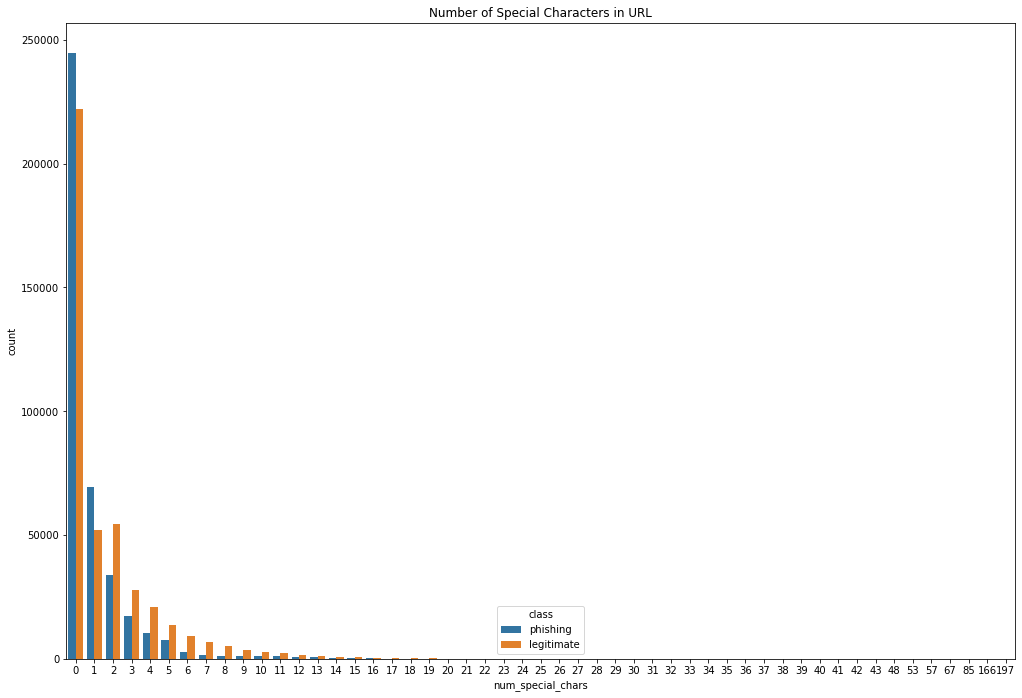

In [138]:

p=sns.countplot(data['num_special_chars'], hue=data['class'])
p.set_title("Number of Special Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)
